- We will be looking at Ames Housing Data set, compiled by Dean De Cock for use in data science education.
- Used by Kaggle for education and competition we will be using Tensorflow to make a Nerual Network for entry into the competition
- Frist we will be inspecting the data looking at what to do with NaN's and "object" type data
      - Wanting to get the most out of the data will be setting NaN's to 0 value instead of dropping.

# Imports 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

from sklearn import set_config
set_config(transform_output = 'pandas')
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

In [2]:
# Custom function for plotting each metric
def plot_history(history, figsize=(6,12), marker='o'):
       
    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]
    
    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)
    
    # For each metric
    for i, metric_name in enumerate(metrics):
    
        # Get the axis for the current metric
        ax = axes[i]
    
        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch
    
        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)
    
        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)
    
        # Final subplot adjustments 
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes



# Data

In [3]:
df=pd.read_csv("Data/train.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df.duplicated().sum()

0

- Checked for duplicates
      - None

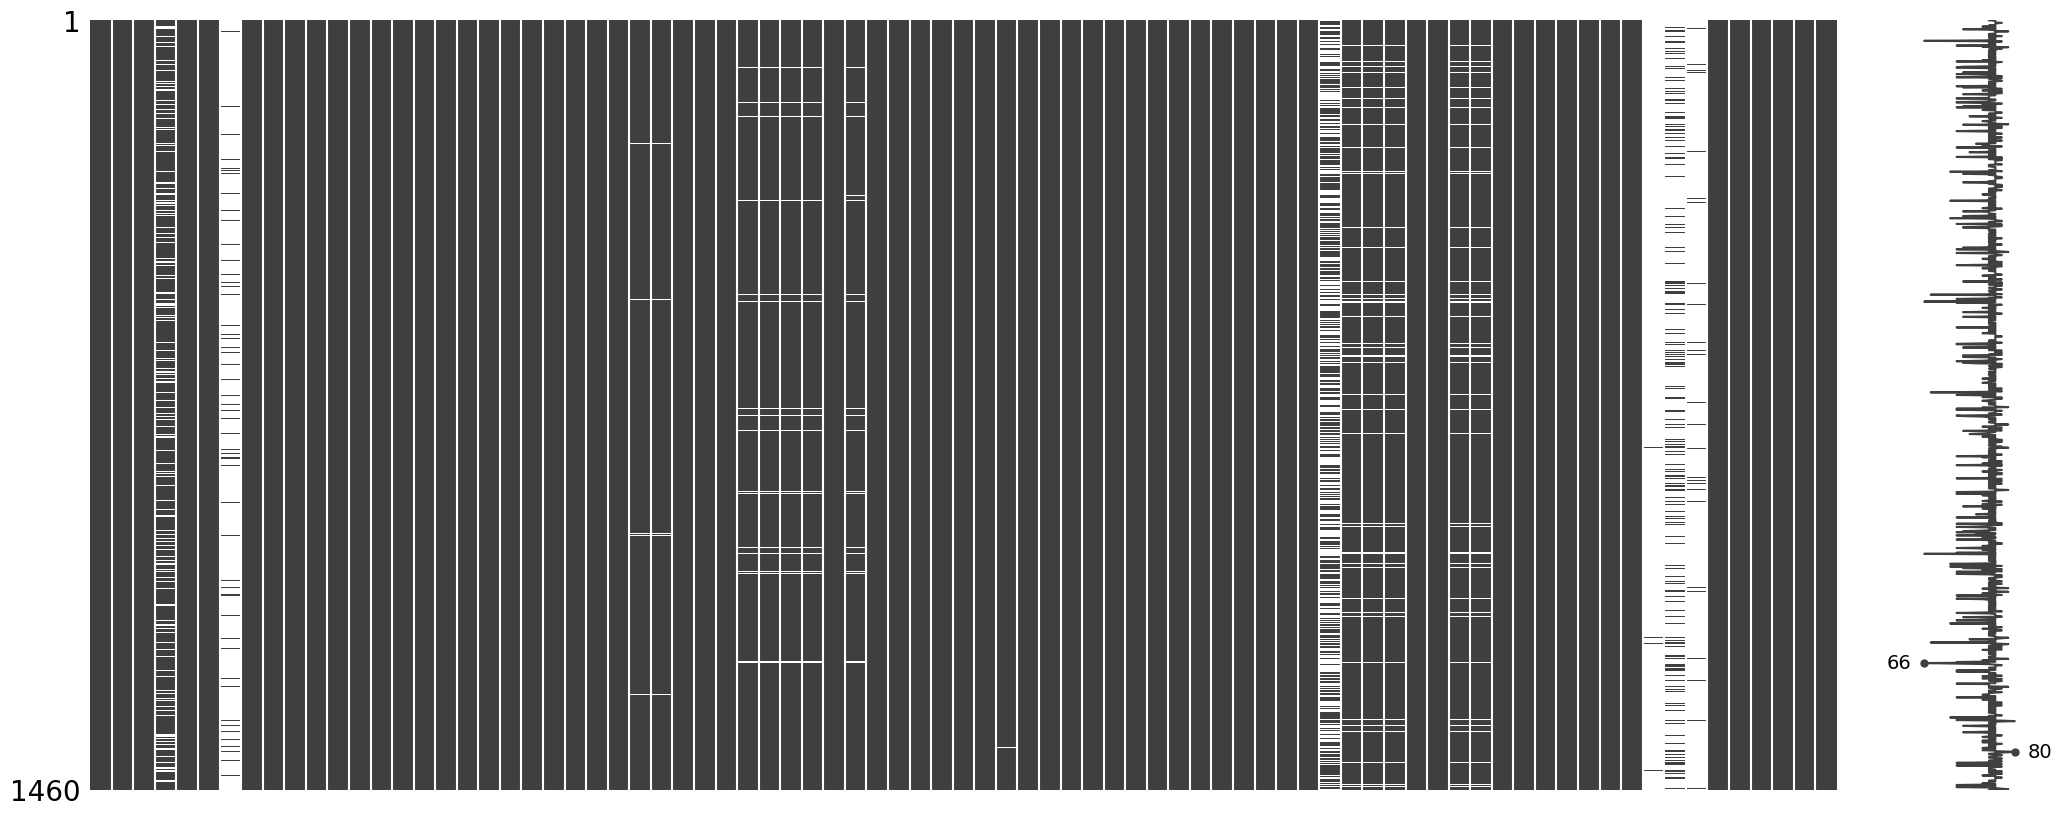

In [5]:
# Getting a visual of what our Missing Data looks like
msno.matrix(df);

In [6]:
df.isna().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

- After reading the data library Missing values/NaN's are houses without particular features.
    - Will be replacing missing values with '0'
- Droping 'Id' and 'MiscFeature'
    - No need for 'Id'
    - Felt "MiscFeture" had too much unknown and unable to organize

In [7]:
df = df.drop(columns=['Id','MiscFeature'])
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
#Wanting a list of "object" columns, columns with strings
cat_col = df.select_dtypes('object').columns
cat_col

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'SaleType',
       'SaleCondition'],
      dtype='object')

Calling value_counts on 'object' columns to see values
- Looking to determind what columns to OneHotEncode and what columns to ordinal encode

In [9]:
for column in df:
    value_counts = df[column].value_counts(dropna=False)
    print(f"Value counts for {column}:\n{value_counts}\n")

Value counts for MSSubClass:
20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

Value counts for MSZoning:
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

Value counts for LotFrontage:
NaN      259
60.0     143
70.0      70
80.0      69
50.0      57
        ... 
137.0      1
38.0       1
33.0       1
150.0      1
46.0       1
Name: LotFrontage, Length: 111, dtype: int64

Value counts for LotArea:
7200     25
9600     24
6000     17
9000     14
8400     14
         ..
14601     1
13682     1
4058      1
17104     1
9717      1
Name: LotArea, Length: 1073, dtype: int64

Value counts for Street:
Pave    1454
Grvl       6
Name: Street, dtype: int64

Value counts for Alley:
NaN     1369
Grvl      50
Pave      41
Name: Alley, dtype: int64

Value counts for LotShape:
Reg    925
IR1    484

In [10]:
qual = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,np.nan:0}
ex_list = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
bsmt_expo = {'Gd':3, 'Av':2, 'Mn':1, 'No':0,}
glq = {'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, np.nan:0}
glq_list = ['BsmtFinType1', 'BsmtFinType2']
function = {'Typ':6, 'Min1':5, 'Min2':4, 'Mod':3, 'Maj1':2, 'Maj2':1, 'Sev':0}
g_fin = {'Fin':3, 'RFn':2, 'Unf':1, np.nan:0}
p_drive = {'Y':2, 'P':1, "N":0}
fenc = {'GdPrv':4, 'MnPrv':3, 'GdWo':2, 'MnWw':1, np.nan:0}

In [11]:
df[ex_list] = df[ex_list].replace(qual)
df['ExterQual'].value_counts(dropna=False)

3    906
4    488
5     52
2     14
Name: ExterQual, dtype: int64

In [12]:
df['BsmtExposure'] = df['BsmtExposure'].replace(np.nan,'No')
df['BsmtExposure'] = df['BsmtExposure'].replace(bsmt_expo)
df['BsmtExposure'].value_counts(dropna=False)

0    991
2    221
3    134
1    114
Name: BsmtExposure, dtype: int64

In [13]:
df[glq_list] = df[glq_list].replace(glq)
df['BsmtFinType1'].value_counts(dropna=False)

1.0    430
6.0    418
5.0    220
4.0    148
3.0    133
2.0     74
0.0     37
Name: BsmtFinType1, dtype: int64

In [14]:
df['Functional'].replace(function,inplace=True)
df['Functional'].value_counts(dropna=False)

6    1360
4      34
5      31
3      15
2      14
1       5
0       1
Name: Functional, dtype: int64

In [15]:
df['GarageFinish'].replace(g_fin,inplace=True)
df['GarageFinish'].value_counts(dropna=False)

1.0    605
2.0    422
3.0    352
0.0     81
Name: GarageFinish, dtype: int64

In [16]:
df['PavedDrive'].replace(p_drive,inplace=True)
df['PavedDrive'].value_counts(dropna=False)

2    1340
0      90
1      30
Name: PavedDrive, dtype: int64

In [17]:
df['Fence'].replace(fenc,inplace=True)
df['Fence'].value_counts(dropna=False)

0.0    1179
3.0     157
4.0      59
2.0      54
1.0      11
Name: Fence, dtype: int64

In [18]:
#NOT WORKING
df['Electrical'].replace(np.nan,'SBrkr',inplace=True)
df['Electrical'].value_counts(dropna=False)

SBrkr    1335
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [19]:
df['Alley'].replace(np.nan,'None',inplace=True)
df['Alley'].value_counts(dropna=False)

None    1369
Grvl      50
Pave      41
Name: Alley, dtype: int64

In [20]:
df['LotFrontage'].replace(np.nan,0,inplace = True)
df['LotFrontage'].value_counts(dropna=False)

0.0      259
60.0     143
70.0      70
80.0      69
50.0      57
        ... 
137.0      1
38.0       1
33.0       1
150.0      1
46.0       1
Name: LotFrontage, Length: 111, dtype: int64

In [21]:
df['GarageType'].replace(np.nan,'None',inplace=True)
df['GarageType'].value_counts(dropna=False)

Attchd     870
Detchd     387
BuiltIn     88
None        81
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64

In [22]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,4,3,PConc,4.0,3.0,0,6.0,706,1.0,0,150,856,GasA,5,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,4,8,6,0,0.0,Attchd,2003.0,2.0,2,548,3.0,3.0,2,0,61,0,0,0,0,0.0,0.0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,3,CBlock,4.0,3.0,3,5.0,978,1.0,0,284,1262,GasA,5,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,3,6,6,1,3.0,Attchd,1976.0,2.0,2,460,3.0,3.0,2,298,0,0,0,0,0,0.0,0.0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,4,3,PConc,4.0,3.0,1,6.0,486,1.0,0,434,920,GasA,5,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,4,6,6,1,3.0,Attchd,2001.0,2.0,2,608,3.0,3.0,2,0,42,0,0,0,0,0.0,0.0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,3,3,BrkTil,3.0,4.0,0,5.0,216,1.0,0,540,756,GasA,4,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,4,7,6,1,4.0,Detchd,1998.0,1.0,3,642,3.0,3.0,2,0,35,272,0,0,0,0.0,0.0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,4,3,PConc,4.0,3.0,2,6.0,655,1.0,0,490,1145,GasA,5,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,4,9,6,1,3.0,Attchd,2000.0,2.0,3,836,3.0,3.0,2,192,84,0,0,0,0,0.0,0.0,0,12,2008,WD,Normal,250000


In [23]:
target=('SalePrice')
y=df[target]
X=df.drop(columns=target)
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42)
X_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1023,120,RL,43.0,3182,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Blmngtn,Norm,Norm,TwnhsE,1Story,7,5,2005,2006,Gable,CompShg,VinylSd,VinylSd,BrkFace,14.0,4,3,PConc,4.0,4.0,0,6.0,16,1.0,0,1330,1346,GasA,5,Y,SBrkr,1504,0,0,1504,0,0,2,0,2,1,4,7,6,1,4.0,Attchd,2005.0,3.0,2,437,3.0,3.0,2,156,20,0,0,0,0,0.0,0.0,0,5,2008,WD,Normal
810,20,RL,78.0,10140,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1974,1999,Hip,CompShg,HdBoard,HdBoard,BrkFace,99.0,3,3,CBlock,3.0,3.0,0,5.0,663,2.0,377,0,1040,GasA,2,Y,SBrkr,1309,0,0,1309,1,0,1,1,3,1,4,5,6,1,2.0,Attchd,1974.0,2.0,2,484,3.0,3.0,2,265,0,0,0,0,648,2.0,4.0,0,1,2006,WD,Normal
1384,50,RL,60.0,9060,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1.5Fin,6,5,1939,1950,Gable,CompShg,WdShing,Wd Shng,None,0.0,3,3,BrkTil,3.0,3.0,1,3.0,204,1.0,0,356,560,GasA,3,Y,SBrkr,698,560,0,1258,0,0,1,0,2,1,3,6,6,0,0.0,Detchd,1939.0,1.0,1,280,3.0,3.0,1,0,0,0,0,0,0,0.0,3.0,0,10,2009,WD,Normal
626,20,RL,0.0,12342,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,5,1960,1978,Hip,CompShg,Wd Sdng,Wd Sdng,None,0.0,3,3,CBlock,3.0,3.0,0,1.0,0,1.0,0,978,978,GasA,3,Y,SBrkr,1422,0,0,1422,0,0,1,0,3,1,3,6,5,1,3.0,Attchd,1960.0,2.0,1,286,3.0,3.0,2,0,0,36,0,0,0,0.0,2.0,600,8,2007,WD,Normal
813,20,RL,75.0,9750,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Gable,CompShg,MetalSd,MetalSd,BrkFace,243.0,3,3,CBlock,3.0,3.0,0,3.0,608,1.0,0,834,1442,GasA,4,Y,SBrkr,1442,0,0,1442,0,0,1,1,4,1,3,7,6,0,0.0,Attchd,1958.0,2.0,1,301,3.0,3.0,2,0,0,275,0,0,0,0.0,0.0,500,4,2007,COD,Normal


In [24]:
X_train.isna().sum()

MSSubClass        0
MSZoning          0
LotFrontage       0
LotArea           0
Street            0
Alley             0
LotShape          0
LandContour       0
Utilities         0
LotConfig         0
LandSlope         0
Neighborhood      0
Condition1        0
Condition2        0
BldgType          0
HouseStyle        0
OverallQual       0
OverallCond       0
YearBuilt         0
YearRemodAdd      0
RoofStyle         0
RoofMatl          0
Exterior1st       0
Exterior2nd       0
MasVnrType        4
MasVnrArea        4
ExterQual         0
ExterCond         0
Foundation        0
BsmtQual          0
BsmtCond          0
BsmtExposure      0
BsmtFinType1      0
BsmtFinSF1        0
BsmtFinType2      0
BsmtFinSF2        0
BsmtUnfSF         0
TotalBsmtSF       0
Heating           0
HeatingQC         0
CentralAir        0
Electrical        0
1stFlrSF          0
2ndFlrSF          0
LowQualFinSF      0
GrLivArea         0
BsmtFullBath      0
BsmtHalfBath      0
FullBath          0
HalfBath          0


In [25]:
num_cols = X_train.select_dtypes('number').columns
ohe_cols = X_train.select_dtypes('object').columns


mmscaler = MinMaxScaler()
num_pipe = make_pipeline(mmscaler)
num_tuple = ('numeric', num_pipe, num_cols)
#num_tuple = ('numeric', mmscaler,num_cols)

ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe_pipe = make_pipeline(ohe_encoder)
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)


col_transformer = ColumnTransformer([num_tuple, ohe_tuple],
                                    verbose_feature_names_out=False)
col_transformer.fit(X_train)

X_train_tf = col_transformer.transform(X_train)
X_test_tf = col_transformer.transform(X_test)
X_train_tf.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,...,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_nan,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1023,0.588235,0.137380,0.008797,0.666667,0.500,0.963768,0.933333,0.010160,0.666667,0.5,0.8,1.00,0.000000,1.000000,0.002835,0.166667,0.000000,0.569349,0.220295,1.00,0.268472,0.000000,0.0,0.220422,0.000000,0.0,0.666667,0.0,0.250,0.333333,0.666667,0.416667,1.000000,0.333333,0.8,0.954545,1.000000,0.50,0.308181,0.6,0.6,1.0,0.182030,0.036563,0.000000,0.0,0.0,0.000000,0.0,0.00,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
810,0.000000,0.249201,0.041319,0.555556,0.625,0.739130,0.816667,0.071843,0.333333,0.5,0.6,0.75,0.000000,0.833333,0.117470,0.333333,0.334516,0.000000,0.170213,0.25,0.223726,0.000000,0.0,0.183685,0.333333,0.0,0.333333,0.5,0.375,0.333333,0.666667,0.250000,1.000000,0.333333,0.4,0.672727,0.666667,0.50,0.341326,0.6,0.6,1.0,0.309218,0.000000,0.000000,0.0,0.0,0.878049,0.4,1.00,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1384,0.176471,0.191693,0.036271,0.555556,0.500,0.485507,0.000000,0.000000,0.333333,0.5,0.6,0.75,0.333333,0.500000,0.036145,0.166667,0.000000,0.152397,0.091653,0.50,0.083525,0.271186,0.0,0.174077,0.000000,0.0,0.333333,0.0,0.250,0.333333,0.333333,0.333333,1.000000,0.000000,0.0,0.354545,0.333333,0.25,0.197461,0.6,0.6,0.5,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.75,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
626,0.000000,0.000000,0.051611,0.444444,0.500,0.637681,0.466667,0.000000,0.333333,0.5,0.6,0.75,0.000000,0.166667,0.000000,0.166667,0.000000,0.418664,0.160065,0.50,0.249656,0.000000,0.0,0.204974,0.000000,0.0,0.333333,0.0,0.375,0.333333,0.333333,0.333333,0.833333,0.333333,0.6,0.545455,0.666667,0.25,0.201693,0.6,0.6,1.0,0.000000,0.000000,0.065217,0.0,0.0,0.000000,0.0,0.50,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
813,0.000000,0.239617,0.039496,0.555556,0.625,0.623188,0.133333,0.176343,0.333333,0.5,0.6,0.75,0.000000,0.500000,0.107725,0.166667,0.000000,0.357021,0.236007,0.75,0.254245,0.000000,0.0,0.208742,0.000000,0.0,0.333333,0.5,0.500,0.333333,0.333333,0.416667,1.000000,0.000000,0.0,0.527273,0.666667,0.25,0.212

In [26]:
input_shape = X_train_tf.shape[1]
input_shape

223

In [27]:
def build_model():
    model = Sequential()
    model.add(Dense(1000,input_dim=input_shape,activation='relu'))
    model.add(Dense(750,activation='relu'))
    #model.add(Dropout(.2))
    model.add(Dense(500,activation='relu'))
    model.add(Dense(1, activation = 'linear'))

    model.compile(loss='mse', optimizer='adam', metrics = [metrics.MeanAbsoluteError(), 
                    metrics.RootMeanSquaredError()])
    return model

In [28]:
reg_model = build_model()
reg_model.summary()

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              224000    
                                                                 
 dense_1 (Dense)             (None, 750)               750750    
                                                                 
 dense_2 (Dense)             (None, 500)               375500    
                                                                 
 dense_3 (Dense)             (None, 1)                 501       
                                                                 
Total params: 1,350,751
Trainable params: 1,350,751
Non-trainable params: 0
_________________________________________________________________


In [29]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [30]:
history = reg_model.fit(X_train_tf, y_train, validation_split=.2, epochs = 100, verbose=0,
                       callbacks = [early_stop])

2023-12-06 21:34:47.825127: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


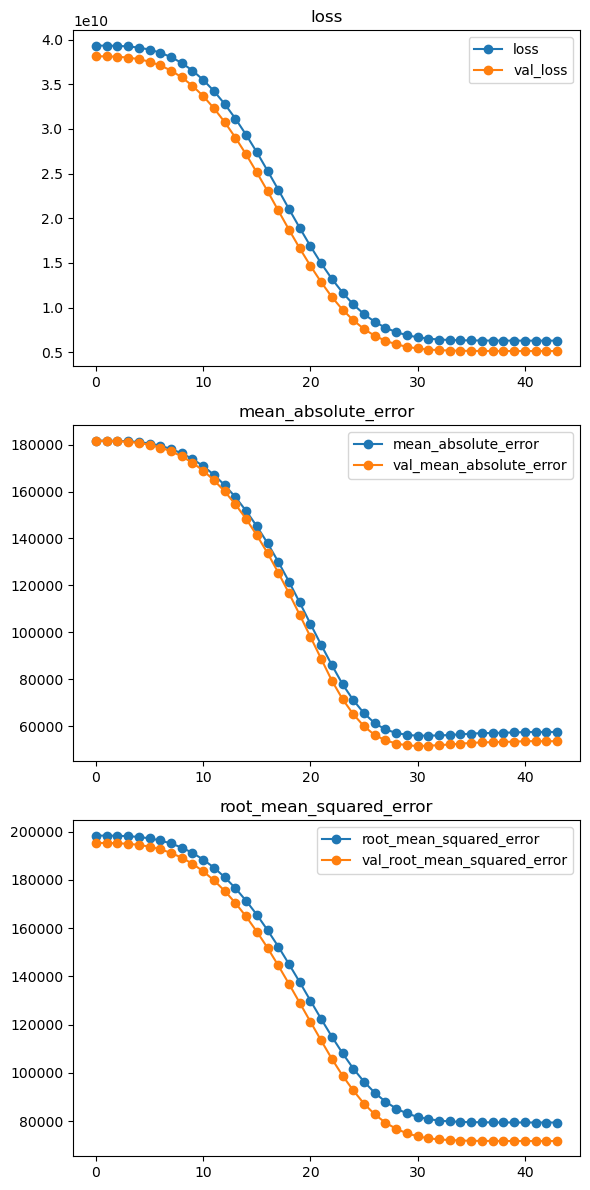

In [31]:
plot_history(history);

In [32]:
y_pred = reg_model.predict(X_test_tf)
print(f'final RMSE: {np.sqrt(mean_squared_error(y_test,y_pred))}')
print(f'final MAE: {mean_absolute_error(y_test,y_pred)}')
print(f'final R2: {r2_score(y_test,y_pred)}')

12/12 [==============================] - 0s 3ms/step
final RMSE: 83744.2641522843
final MAE: 60009.97063356164
final R2: -0.0011124028947224751


ohe_col=X_train.select_dtypes('object').columns
ohe_col

df[ohe_col].fillna(0, inplace=True)

ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe_encoder.fit(X_train[ohe_col])

X_train_ohe = ohe_encoder.transform(X_train[ohe_col])
X_test_ohe = ohe_encoder.transform(X_test[ohe_col])


X_test_ohe.head()
#ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
#ohe_encoder.fit_transform(df[ohe_col])


X_train_ohe.shape

mmscaler=MinMaxScaler()
X_train_tf=mmscaler.fit_transform(X_train_ohe)